# T1D SNPs

In [20]:
import glob
import os

import matplotlib.pyplot as plt
import myvariant
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## iPSC eQTLs

In [2]:
snps = pd.read_table('/projects/CARDIPS/analysis/t1d_grant/T1D_sig.txt')

In [3]:
mv = myvariant.MyVariantInfo()

pos = []
for s in snps['SNPs']:
    res = mv.query(s)
    chrom,rest = res['hits'][0]['_id'].split(':')
    start = int(rest.split('.')[1][:-3])
    end = start + 1
    pos.append([chrom, start, end])
    
df = pd.DataFrame(pos, columns=['chrom', 'start', 'end'])
snps = snps.join(df)

In [4]:
fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_processing/gene_variant_pairs.tsv'
gv = pd.read_table(fn, low_memory=False)
gv.index = gv.chrom + ':' + gv.beg.astype(str)

In [5]:
fn = '/publicdata/gencode_v19_20151104/gene_info.tsv'
gene_info = pd.read_table(fn, index_col=0)

In [6]:
ens = []
gs = []
for i in snps.chrom + ':' + snps.start.astype(str):
    try:
        se = gv.ix[i, 'gene']
        if type(se) == str:
            ens.append(se)
            gs.append(gene_info.ix[se, 'gene_name'])
        else:
            ens.append(','.join(se.values))
            gs.append(','.join(gene_info.ix[se.values, 'gene_name']))
    except KeyError:
        ens.append(np.nan)
        gs.append(np.nan)

In [7]:
snps['iPSC_eqtl_gencode'] = ens
snps['iPSC_eqtl_symbol'] = gs

In [9]:
snps.ipsc_eqtl_gencode.dropna().shape

(22,)

## GTEx eQTLs

In [10]:
# This file has the probability of the SNP being a QTL for each tissue
# for the top SNP for that gene.
fn = ('/publicdata/gtex_20151104/Multi_tissue_eQTL_GTEx_Pilot_Phase_datasets/'
      'res_final_amean_com_genes_com_snps.txt')
multi_probs = pd.read_table(fn, index_col=0)

# Single tissue results.
fns = glob.glob('/publicdata/gtex_20151104/*.eqtl')
gtex_results = {}
for fn in fns:
    gtex_results[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
                                                                     low_memory=False)

In [11]:
res = {}
for k in gtex_results.keys():
    gdf = gtex_results[k]
    ens = []
    gs = []
    for i in snps.index:
        if snps.ix[i, 'chrom'] == 'chrX':
            ens.append(np.nan)
            gs.append(np.nan)
        else:
            tdf = gdf[(gdf.SNP_Chr == int(snps.ix[i, 'chrom'][3:])) & 
                      (gdf.SNP_Pos == snps.ix[i, 'start'])]
            if tdf.shape[0] > 0:
                ens.append(','.join(tdf.Gen_ID.values))
                gs.append(','.join(tdf.Gene_Name))
            else:
                ens.append(np.nan)
                gs.append(np.nan)
    res['{}_eqtl_gencode'.format(k)] = ens
    res['{}_eqtl_symbol'.format(k)] = gs
    
t = pd.DataFrame(res)
snps = snps.join(t)

In [33]:
tdf = snps[[x for x in snps.columns if 'eqtl_symbol' in x]]
tdf.columns = [x[:-12].replace('_', ' ') for x in tdf.columns]

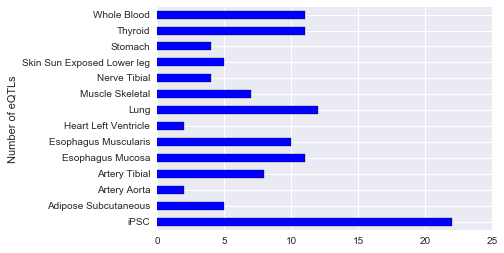

In [34]:
(tdf.shape[0] - tdf.isnull().sum()).plot(kind='barh')
plt.ylabel('Number of eQTLs');

In [13]:
snps.to_csv('t1d_snps.tsv', sep='\t')